# Model 2: VGG16 tuned

The below model run consists of a tuned version of VGG16 

In [95]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"marshnick","key":"5750c27e68d91d0db4a2b35d082318c3"}'}

In [96]:
!mkdir /root/.kaggle
!cp kaggle.json /root/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json 
!kaggle datasets download -d andrewmvd/car-plate-detection --force
!unzip -o -qq car-plate-detection.zip 

mkdir: cannot create directory ‘/root/.kaggle’: File exists
 99% 202M/203M [00:10<00:00, 24.5MB/s]
100% 203M/203M [00:10<00:00, 20.9MB/s]


In [97]:
%matplotlib inline

import pandas as pd
import os
import glob
import cv2
import numpy as np
from lxml import etree
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split


## Preparing the Training and Test DataSet

In [98]:
IMAGE_SIZE = 224
IMAGE_DIR = os.getcwd() + '/images/'
ANNOTATIONS_DIR = os.getcwd() + '/annotations/'

In [99]:
data_path = os.path.join(IMAGE_DIR,'*g')
files = glob.glob(data_path)


In [100]:
## The image is resized to 224*224 and stored in an array X 
files.sort() #We sort the images in alphabetical order to match them to the xml files containing the annotations of the bounding boxes
X=[]
for f1 in files:
    img = cv2.imread(f1)
    img = cv2.resize(img, (IMAGE_SIZE,IMAGE_SIZE))
    #kernel_sharpening = np.array([[-1,-1,-1], 
    #                          [-1,9,-1], 
    #                          [-1,-1,-1]])
    #img = cv2.filter2D(img, -1, kernel_sharpening)
    #img = cv2.medianBlur(img,5)
    X.append(np.array(img))

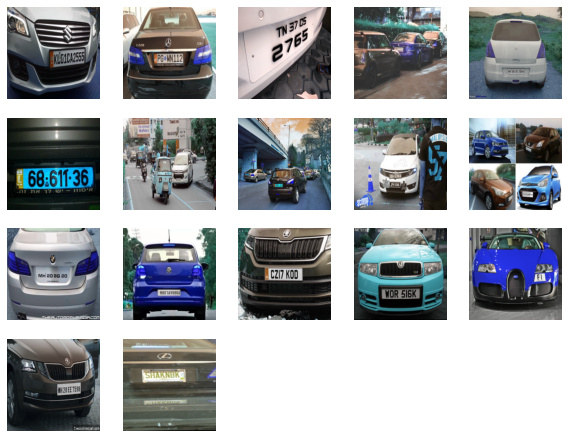

In [101]:
### Sample images shown below
plt.figure(figsize=(10,20))
for i in range(0,17) :
    plt.subplot(10,5,i+1)
    plt.axis('off')
    plt.imshow(X[i])

In [102]:
### The following function picks up the boundaries of the license plate from the image annnotations.
### xmin, xmax, ymin, ymax denote the 4 co-ordinates
### The co-ordinates are rescaled to the 224*224 co-ordinate system

def resizeannotation(f):
    tree = etree.parse(f)
    for dim in tree.xpath("size"):
        width = int(dim.xpath("width")[0].text)
        height = int(dim.xpath("height")[0].text)
    for dim in tree.xpath("object/bndbox"):
        xmin = int(dim.xpath("xmin")[0].text)/(width/IMAGE_SIZE)
        ymin = int(dim.xpath("ymin")[0].text)/(height/IMAGE_SIZE)
        xmax = int(dim.xpath("xmax")[0].text)/(width/IMAGE_SIZE)
        ymax = int(dim.xpath("ymax")[0].text)/(height/IMAGE_SIZE)
    return [int(xmax), int(ymax), int(xmin), int(ymin)]

In [103]:
### Stores the location of xml files of each Car image
text_files = [ANNOTATIONS_DIR+f for f in sorted(os.listdir(ANNOTATIONS_DIR))]

In [104]:
### The Boundaries are extracted from each XML File
y=[]
for i in text_files:
    y.append(resizeannotation(i))

In [105]:
#Transforming in array
X=np.array(X)
y=np.array(y)

X = X / 255
y = y / 255

In [138]:
# Test train Dataset split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=1)

In [139]:
### Importing the keras model Sequential

from keras.models import Sequential,Model
from keras.layers import Dense, Flatten
from keras.applications.vgg16 import VGG16

In [140]:
# Create the model
# We are using VGG16 as a regression model to predict the boundaries of the license plate
# The model has been tuned to optimise validation accuracy

# model = Sequential()
# model.add(VGG16(weights="imagenet", include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
# model.add(Flatten())
# model.add(Dense(128, activation="relu"))
# model.add(Dense(128, activation="relu"))
# model.add(Dense(64, activation="relu"))
# model.add(Dense(4, activation="sigmoid"))

# ### VGG16 Layer frozen for transfer learning
# model.layers[-6].trainable = False




vgg=VGG16(weights="imagenet", include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
for layer in vgg.layers[:17]:
    layer.trainable = False

for i, layer in enumerate(vgg.layers):
    print(i, layer.name, layer.trainable)


x=Flatten()(vgg.output)
x=Dense(128, activation="relu")(x)
x=Dense(128, activation="relu")(x)
x=Dense(64, activation="relu")(x)
x=Dense(32, activation="relu")(x)
x=Dense(16, activation="relu")(x)
#x=Dense(8, activation="relu")(x)
x=Dense(4,activation="sigmoid")(x)

model=Model(inputs=vgg.input,outputs=x)


model.summary()


0 input_18 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool False
11 block4_conv1 False
12 block4_conv2 False
13 block4_conv3 False
14 block4_pool False
15 block5_conv1 False
16 block5_conv2 False
17 block5_conv3 True
18 block5_pool True
Model: "model_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_18 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0 

In [141]:
### We are using mean squared error loss function
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['MeanAbsoluteError'])

In [142]:
train = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=32, verbose=1)

Epoch 1/50
10/10 [==============================] - 3s 209ms/step - loss: 0.0383 - mean_absolute_error: 0.1530 - val_loss: 0.0221 - val_mean_absolute_error: 0.1115
Epoch 2/50
10/10 [==============================] - 2s 172ms/step - loss: 0.0185 - mean_absolute_error: 0.1030 - val_loss: 0.0159 - val_mean_absolute_error: 0.0913
Epoch 3/50
10/10 [==============================] - 2s 171ms/step - loss: 0.0122 - mean_absolute_error: 0.0825 - val_loss: 0.0152 - val_mean_absolute_error: 0.0810
Epoch 4/50
10/10 [==============================] - 2s 171ms/step - loss: 0.0073 - mean_absolute_error: 0.0622 - val_loss: 0.0138 - val_mean_absolute_error: 0.0721
Epoch 5/50
10/10 [==============================] - 2s 171ms/step - loss: 0.0048 - mean_absolute_error: 0.0507 - val_loss: 0.0135 - val_mean_absolute_error: 0.0672
Epoch 6/50
10/10 [==============================] - 2s 171ms/step - loss: 0.0034 - mean_absolute_error: 0.0430 - val_loss: 0.0145 - val_mean_absolute_error: 0.0618
Epoch 7/50
10/10

In [143]:
# Image Augmentation


# from keras.preprocessing.image import ImageDataGenerator

# train_datagen = ImageDataGenerator(zoom_range=0.2, rotation_range=30, width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2)
# #Fit augmentation to training images
# train_generator = train_datagen.flow(X_train,y_train,batch_size=1)
# model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

# train = model.fit(train_generator, validation_data=(X_val, y_val), epochs=50, batch_size=32, verbose=1)

In [144]:
model.save('my_model.h5', overwrite=True) 


In [145]:
X_test[0].shape

(224, 224, 3)

In [146]:
# Test
scores = model.evaluate(X_test, y_test, verbose=0)
print("Score : %.2f%%" % (scores[1]*100))

Score : 3.86%


In [147]:
train.history.keys()

dict_keys(['loss', 'mean_absolute_error', 'val_loss', 'val_mean_absolute_error'])

In [148]:
def plot_scores(train) :
    accuracy = train.history['mean_absolute_error']
    val_accuracy = train.history['val_mean_absolute_error']
    epochs = range(len(accuracy))
    plt.plot(epochs, accuracy, 'b', label='Error train')
    plt.plot(epochs, val_accuracy, 'r', label='Error testing')
    plt.title('VGG16 tuned with added layers')
    plt.legend()
    plt.show()

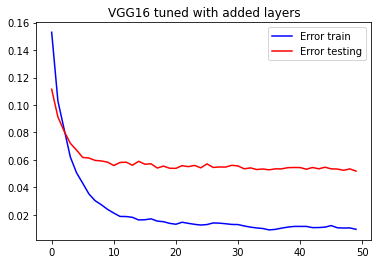

In [149]:
plot_scores(train)

In [150]:
test_loss, test_accuracy = model.evaluate(X_test, y_test,steps=int(100))

print("Test results \n Loss:",test_loss,'\n Mean Absolute Error',test_accuracy)

 83/100 [=======================>......] - ETA: 0s - loss: 0.0046 - mean_absolute_error: 0.0385

100/100 [==============================] - 1s 9ms/step - loss: 0.0045 - mean_absolute_error: 0.0386
Test results 
 Loss: 0.004547929856926203 
 Mean Absolute Error 0.03860512375831604


In [151]:
train.history.keys()

dict_keys(['loss', 'mean_absolute_error', 'val_loss', 'val_mean_absolute_error'])

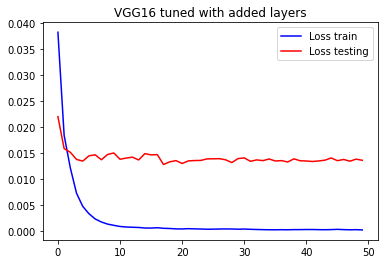

In [152]:
def plot_loss_scores(train) :
    accuracy = train.history['loss']
    val_accuracy = train.history['val_loss']
    epochs = range(len(accuracy))
    plt.plot(epochs, accuracy, 'b', label='Loss train')
    plt.plot(epochs, val_accuracy, 'r', label='Loss testing')
    plt.title('VGG16 tuned with added layers')
    plt.legend()
    plt.show()
plot_loss_scores(train)

In [153]:
y_cnn = model.predict(X_test)

3/3 [==============================] - 0s 144ms/step


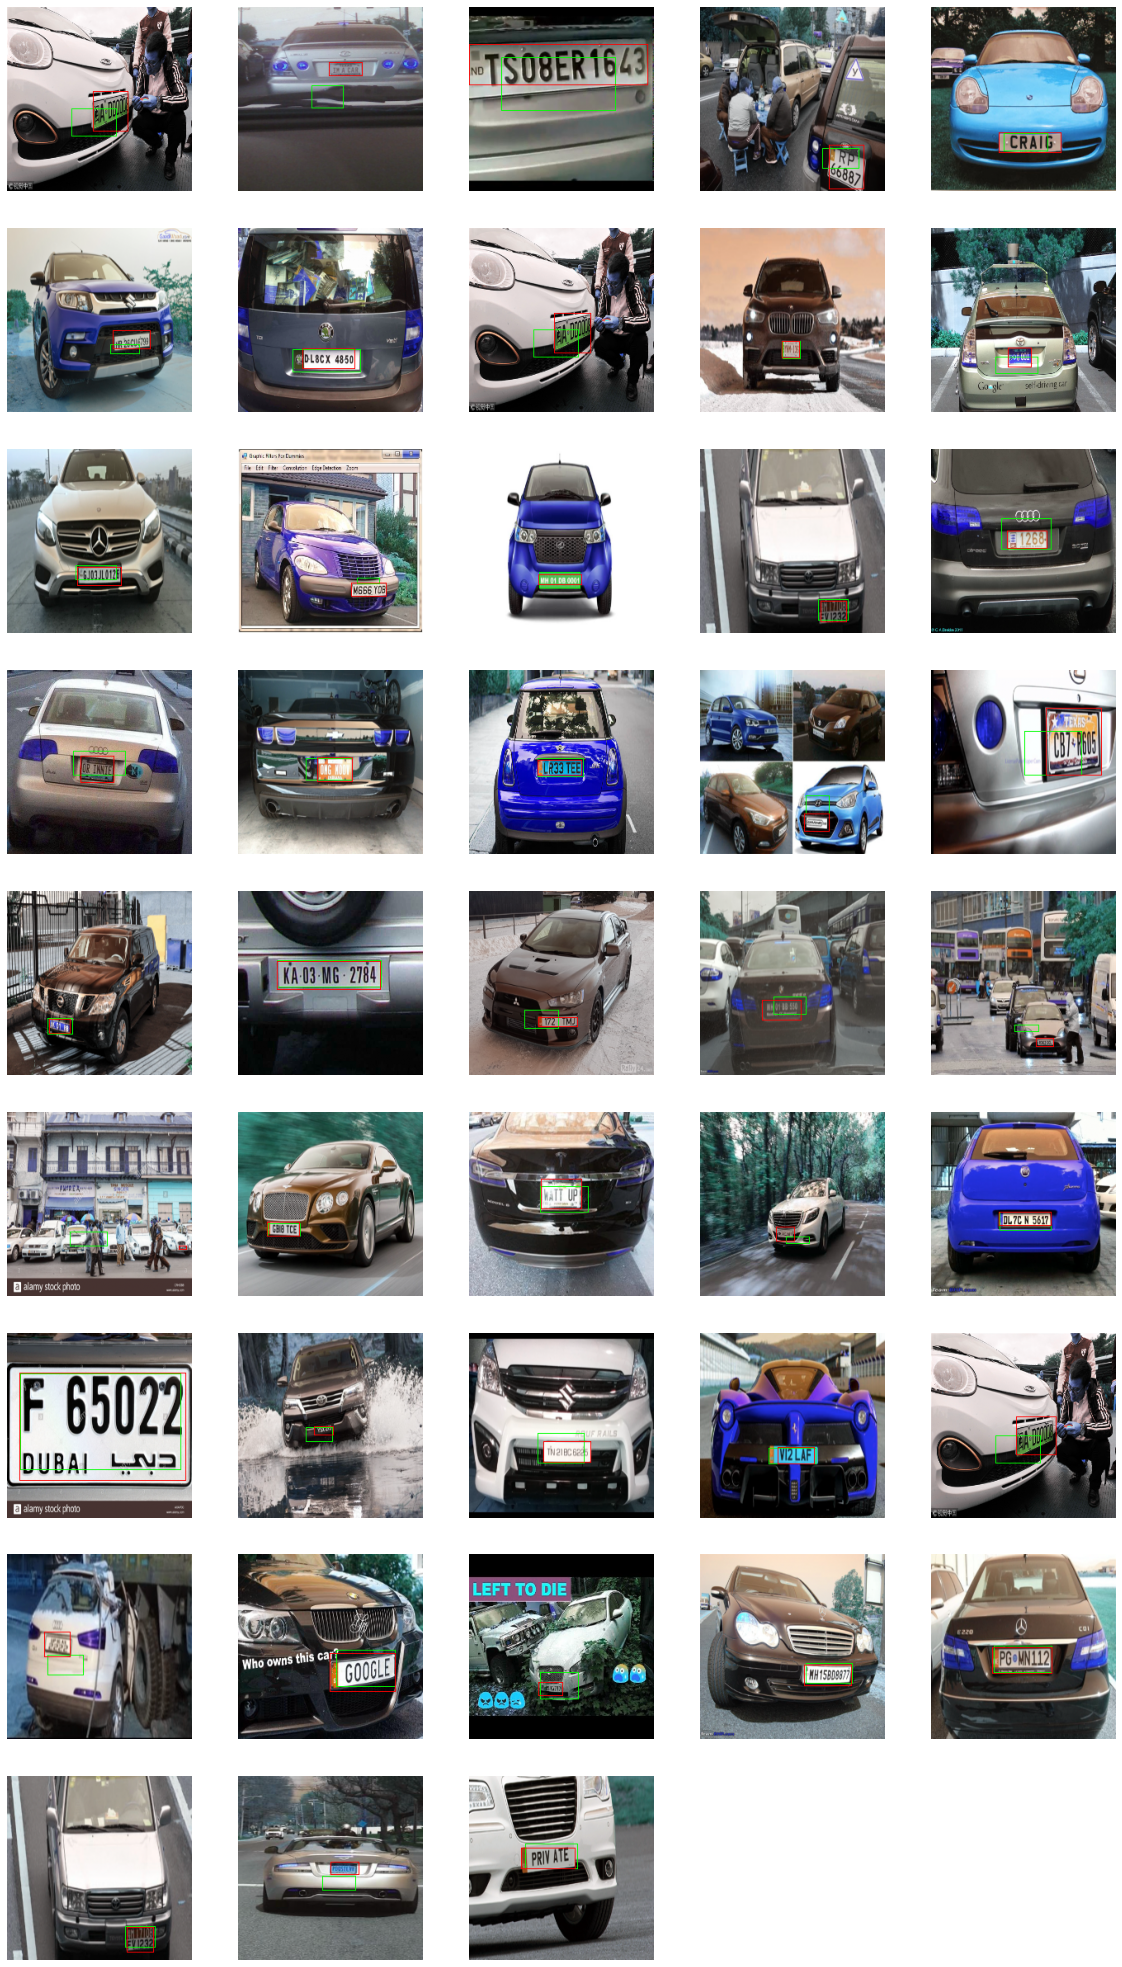

In [154]:
### Plotting the boundaries based on prediction
plt.figure(figsize=(20,40))
for i in range(0,43) :
    plt.subplot(10,5,i+1)
    plt.axis('off')
    ny = y_cnn[i]*255
    nt = y_test[i]*255
    image = cv2.rectangle(X_test[i],(int(ny[0]),int(ny[1])),(int(ny[2]),int(ny[3])),(0, 255, 0))
    cv2.rectangle(image,(int(nt[0]),int(nt[1])),(int(nt[2]),int(nt[3])),(255,0, 0))
    plt.imshow(image)
